In [1]:
import numpy as np

# TODO Remove all that have more than 1 class and train in a single-labeled way instead
# Do filtering here, and copy notebook instead.


def split_test_train(data, train_perc):
    train_num = int(len(data)*train_perc)

    return (
        (
            np.array([t["emotions"] for t in data[:train_num]]),
            np.array([t["genres"] for t in data[:train_num]])
        ),
        (
            np.array([t["emotions"] for t in data[train_num:]]),
            np.array([t["genres"] for t in data[train_num:]])
        )
    )


def split_x_y(data):
    return (
        np.array([t["emotions"] for t in data]),
        np.array([t["genres"] for t in data])
    )

In [2]:
import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense


tf.keras.backend.clear_session()
tf.get_logger().setLevel("ERROR")


def get_model(input_dim, hidden_dim, output_dim, lr=0.01):
    if hidden_dim:
        model = Sequential([
            Dense(hidden_dim[0], input_dim=input_dim, activation='relu')
        ])

        for h in hidden_dim[1:]:
            model.add(Dense(h, activation="relu"))
        model.add(Dense(output_dim, activation='sigmoid'))
    else:
        model = Sequential([
            Dense(output_dim, input_dim=input_dim, activation='sigmoid')
        ])
    
    hamming_loss = tfa.metrics.HammingLoss(mode="multilabel", threshold=.5)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[hamming_loss])
    return model

In [32]:
from sklearn.metrics import hamming_loss as sk_hamming_loss, f1_score as sk_f1_score
from sklearn.model_selection import RepeatedKFold


def hamming_loss(y_pred, y_true):
    return sk_hamming_loss(y_true, y_pred)


def f1_score(y_pred, y_true):
    return sk_f1_score(y_true, y_pred, average="weighted")


def evaluate(x, y, threshold=.5):
    hamming_losses = []
    f1_scores = []
    input_dim, output_dim = x.shape[1], y.shape[1]

    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

    for i, (train_i, test_i) in enumerate(cv.split(x)):
        x_train, x_test = x[train_i], x[test_i]
        y_train, y_test = y[train_i], y[test_i]

        model = get_model(input_dim=input_dim, hidden_dim=[40, 20], output_dim=output_dim, lr=0.001)
        history = model.fit(x_train, y_train, verbose=0, epochs=300)
    
        y_pred = model.predict(x_test)
        binary_pred = [[round(y_val-threshold+.5) for y_val in pred] for pred in y_pred]

        hamming_losses.append(hamming_loss(binary_pred, y_test))
        f1_scores.append(f1_score(binary_pred, y_test))

        print("%s: %.3f" % (i+1, f1_scores[-1]))

        # acc = rounding_acc(model, x_test, y_test)
        # results.append(acc)

        # print("%s: %.3f" % (i, mean(results)))
    return hamming_losses, f1_scores

In [34]:
import json


with open("nrc/nrc_vect.json") as file:
    data = json.load(file)

x, y = split_x_y(data["movies"])
labels = data["genre_order"]

In [35]:
hamming_losses, f1_scores = evaluate(x, y)

print("Avg. hamming loss: %.3f (std.dev: %.3f)" % (np.mean(hamming_losses), np.std(hamming_losses)))
print("Avg. f1-score: %.3f (std.dev: %.3f)" % (np.mean(f1_scores), np.std(f1_scores)))

1: 0.550
2: 0.484
3: 0.564
4: 0.463
5: 0.542
6: 0.542
7: 0.509
8: 0.565
9: 0.611
10: 0.611
11: 0.619
12: 0.605
13: 0.564
14: 0.592
15: 0.488
16: 0.551
17: 0.633
18: 0.460
19: 0.483
20: 0.520
21: 0.526
22: 0.603
23: 0.530
24: 0.537
25: 0.601
26: 0.525
27: 0.547
28: 0.494
29: 0.567
30: 0.540
Avg. hamming loss: 0.261 (std.dev: 0.028)
Avg. f1-score: 0.547 (std.dev: 0.047)


In [30]:
input_dim, output_dim = x.shape[1], y.shape[1]

(x_train, y_train), (x_test, y_test) = split_test_train(data["movies"], .9)

model = get_model(input_dim=input_dim, hidden_dim=[40, 20], output_dim=output_dim, lr=0.001)
history = model.fit(x_train, y_train, verbose=0, epochs=600)

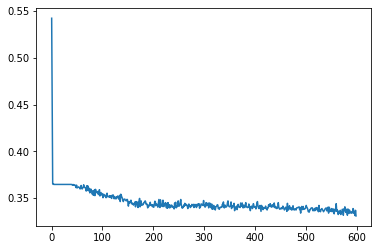

In [31]:
import matplotlib.pyplot as plt

plt.plot(history.history["hamming_loss"])

In [169]:
model.predict(np.array([[
        0.07886042065009584,
        0.14055717017208438,
        0.046357552581262014,
        0.0999644359464626,
        0.16190516252390144,
        0.08229292543021047,
        0.059352963671128196,
        0.16139617590822164
      ],[
        0.0876876332622601,
        0.11341151385927517,
        0.042800639658848595,
        0.11864765458422175,
        0.15406289978678045,
        0.10176759061833693,
        0.04780597014925365,
        0.17779317697228159
      ],[
        0.05391297208538589,
        0.10879474548440066,
        0.043482758620689635,
        0.09275615763546799,
        0.1309581280788178,
        0.09154844006568143,
        0.051869458128078805,
        0.15095566502463056
      ]]))

array([[0.10087365, 0.79002213, 0.35903656, 0.15015492],
       [0.25807378, 0.47197703, 0.4285428 , 0.32059854],
       [0.06975549, 0.30648285, 0.2661515 , 0.59637856]], dtype=float32)